Lab 5, Aleksandr Berezutskii, group 4, Skoltech 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Tracking of a moving object which trajectory is disturbed by random acceleration

The objective of this laboratory work is to develop standard Kalman filter for tracking a moving object which trajectory is disturbed by random acceleration. Important outcome of this exercise is getting deeper understanding of Kalman filter parameters and their role in estimation. We will analyze the sensitivity of estimations to choice of non -optimal parameters and dependence on initial conditions.

Let's generate a true trajectory $X_i$ of an object motion disturbed by normally distributed random acceleration

$$
x_i = x_{i-1} + V_{i-1}T + \cfrac{a_{i-1}T^2}{2}
$$

$$
V_i = V_{i−1} + a_{i-1}T
$$

Size of trajectory is 200 points. Initial conditions:

$$
x_1 = 5
$$

$$
V_1 = 1
$$

$$
T = 1
$$

Variance of acceleration noise $a_i$, $\sigma_a^2 = 0.2^2$


In [2]:
#noise of acceleration
sigmaacc = 0.2
acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)

#steps, speed and time interval
x = np.zeros(len(acc))
x[0] = 5

V = np.zeros(len(acc))
V[0] = 1

T = 1

#trajectory
for i in range(len(acc)):
    x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
    V[i] = V[i-1] + acc[i-1]*T

Let's generate measurements $z_i$ of the coordinate $x_i$

$$
z_i = x_i + \eta_i
$$

where $\eta_i$ is normally distributed random noise with zero mathematical expectation and variance $\sigma_\eta^2 = 20^2$

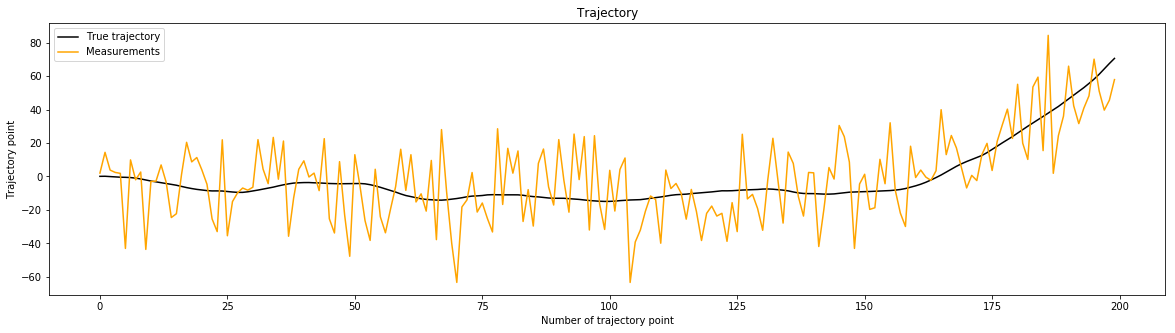

In [3]:
#noise of measurements
sigmaeta = 20
eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)

#measurements of the steps
z = np.zeros(len(acc))
for i in range(len(acc)):
    z[i] = x[i] + eta[i]
    
plt.figure(figsize=(20,5))
plt.plot(x, '-', color='black')
plt.plot(z, '-', color='orange')
plt.title('Trajectory')
plt.ylabel('Trajectory point')
plt.xlabel('Number of trajectory point')
plt.legend(['True trajectory', 'Measurements'], loc = 'best')
plt.show()

Now we will represent the system in state space taking into account that only measurements of coordinate $x_i$ are available.
$$
X_i = \Phi X_{i-1} + G a_{i-1}
$$
$$
z_i = H X_i + \eta_i
$$

1. 
$$
X_i = 
\begin{vmatrix}
x_i \\
V_i
\end{vmatrix}
$$
is the state vector, that describes full state of the system (coordinate $x_i$ and velocity $V_i$)

2. 
$$
\Phi = 
\begin{vmatrix}
1 & T \\
0 & 1
\end{vmatrix}
$$
is transition matrix that relates $X_i$ and $X_{i-1}$

3. 
$$
G = 
\begin{vmatrix}
\frac{T^2}{2} \\
T
\end{vmatrix}
$$
is input matrix, that determines how random acceleration 𝑎𝑖 affects state vector

4. $z_i$ – measurements of a coordinate $x_i$

5. 
$$
H = 
\begin{vmatrix}
1 & 0 
\end{vmatrix}
$$
is the observation matrix

In [4]:
#making state vectors
X = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    X[i,0] = x[i]
    X[i,1] = V[i]
    X[i] = np.matrix([[x[i]], [V[i]]])
    
#making a transition matrix
PHI = np.matrix([[1, T], [0, 1]])

#making an input matrix
G = np.matrix([[T**2/2],[T]])

#making an observation matrix
H = np.matrix([1, 0])

Let's now check our vector state representation, putting every term in our equations on one side, thus we should have zeros on the other side

In [5]:
PHI @ X[4] + acc[4]*G - X[5]

matrix([[ 0.],
        [ 0.]])

In [6]:
H @ X[5] + eta[5] - z[5]

matrix([[ 0.]])

Everything's ok, let's move futher

Let us now develop Kalman filter algorithm to estimate state vector $X_i$ (extrapolation and filtration). We will be consulting charts from lecture Topic_3_Optimal approximation at state space.pdf The initial conditions will be as follows.

Initial filtered estimate
$$
X_0 = 
\begin{vmatrix}
2 \\
0
\end{vmatrix}
$$

Initial filtration error covariance matrix
$$
P_{0} = 
\begin{vmatrix}
10000 & 0 \\
0 & 10000
\end{vmatrix}
$$


To calculate covariance matrix $Q$ of state noise $G a_{i-1}$ that is used in Kalman filter algorithm to determine prediction error covariance matrix use the following equation:
$$
Q = E[(G a_{i-1})(G a_{i-1})^T] = GE[a_{i-1}^2]G^T = \sigma_a^2 GG^T
$$


To calculate covariance matrix $R$ of measurements noise $\eta_i$ that is used in Kalman filter algorithm to determine filter gain we'll use the following recommendation: Dimension of covariance matrix $R$ is determined by a number of state vector components that are measured. In this particular case, only coordinate $x_i$ is measured, thus $R = \sigma_\eta^2$


In [7]:
#initial filtered estimate
X[0] = np.matrix([[2],[0]])

#initial filtration error covariance matrix
P = np.zeros((len(acc), 2, 2))
for i in range(len(acc)):
    P[i] = np.matrix([[0, 0], [0, 0]])
P[0] = np.matrix([[10**4, 0], [0, 10**4]])

#covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
Q = (sigmaacc**2) * (G @ G.T)

#covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
R = np.matrix([sigmaeta**2])
e = np.zeros(len(acc))
K = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    K[i] = np.matrix([[0], [0]])

#Let's start Kalman filter algorithm
for i in range(1, len(acc)):
    #Prediction(extrapolation)
    X[i] = PHI @ X[i-1]
    P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
    e[i] = (H @ P[i] @ H.T + R)**(-1)
    K[i] = e[i] * (P[i] @ H.T)
    X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
    P[i] = (np.identity(2) - K[i] @ H) @ P[i]

Now that we've run Kalman filter algorithm, let's plot the results, including true trajectory, measurements, filtered estimates of state vector $X_i$

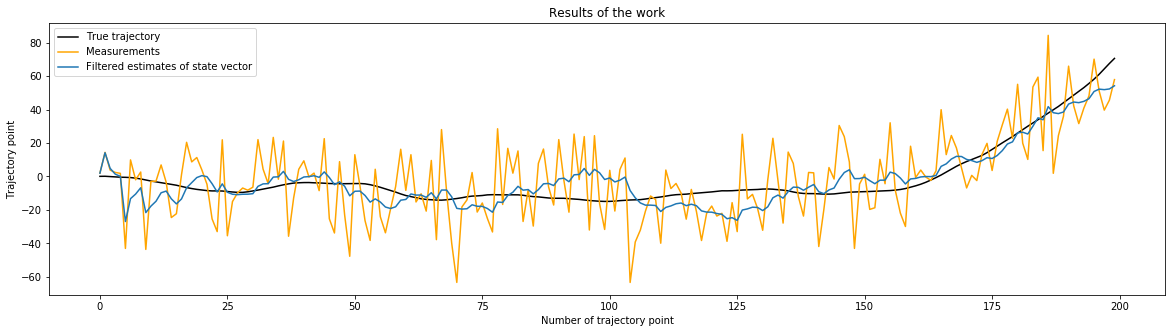

In [8]:
plt.figure(figsize=(20,5))
plt.plot(x, '-', color='black')
plt.plot(z, '-', color='orange')
plt.plot(X[:,0,0], '-')
plt.title('Results of the work')
plt.ylabel('Trajectory point')
plt.xlabel('Number of trajectory point')
plt.legend(['True trajectory', 'Measurements', 'Filtered estimates of state vector'], loc = 'best')
plt.show()

Let's plot filter gain $K$ over the whole filtration interval

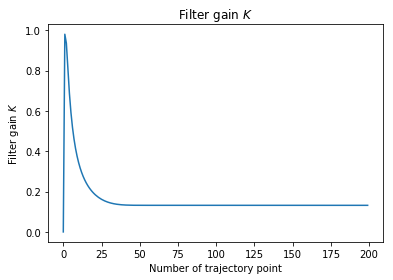

In [9]:
plt.plot(K[:,0], '-')
plt.xlabel('Number of trajectory point')
plt.ylabel('Filter gain $K$')
plt.title('Filter gain $K$')
plt.show()

To analyze filtration error covariance matrix $P_i$ over observation period, we should also make another plot of square root of its first diagonal element corresponding to standard deviation of estimation error of coordinate $x_i$

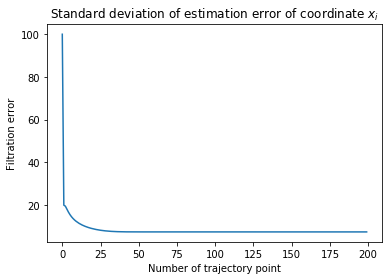

In [10]:
plt.plot(np.sqrt(P[:, 0, 0]), '-')
plt.xlabel('Number of trajectory point')
plt.ylabel('Filtration error')
plt.title('Standard deviation of estimation error of coordinate $x_i$')
plt.show()

We can see that filter gain $K$ and filtration error covariance matrix become constant very quickly. It means that in conditions of a trajectory disturbed by random noise we cannot estimate more than established limit of accuracy due to uncertainty.

Now we will add to the code extrapolation on $m = 7$ steps ahead on every time step

In [13]:
#initial filtered estimate
X[0] = np.matrix([[2],[0]])

#initial filtration error covariance matrix
P = np.zeros((len(acc), 2, 2))
for i in range(len(acc)):
    P[i] = np.matrix([[0, 0], [0, 0]])
P[0] = np.matrix([[10**4, 0], [0, 10**4]])

#covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
Q = (sigmaacc**2) * (G @ G.T)

#covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
R = np.matrix([sigmaeta**2])

e = np.zeros(len(acc))
K = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    K[i] = np.matrix([[0], [0]])

    
#making another state vector
Y = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    Y[i,0] = x[i]
    Y[i,1] = V[i]
    Y[i] = np.matrix([[x[i]], [V[i]]])    

m=7
#Let's start m-step extrapolation
for i in range(len(acc) - m):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
        #Let's start m-step extrapolation
        m=7
        Y[i+m-1] = np.linalg.matrix_power(PHI, m-1) @ X[i]

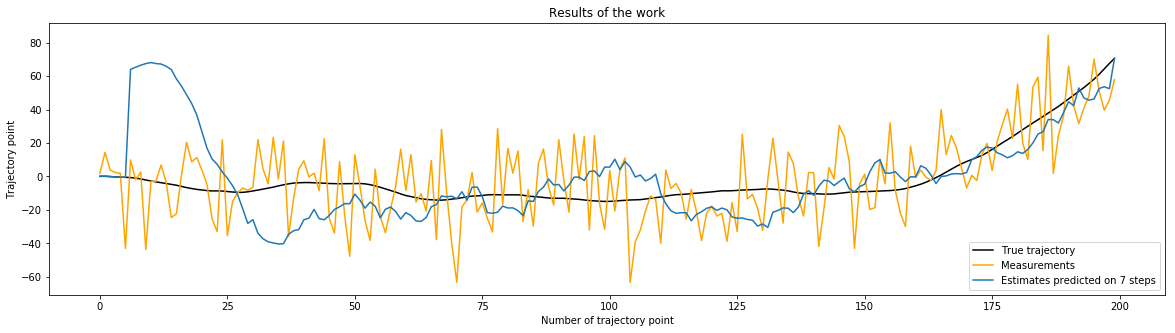

In [14]:
plt.figure(figsize=(20,5))
plt.plot(x, '-', color='black')
plt.plot(z, '-', color='orange')
plt.plot(Y[:,0,0], '-')
plt.title('Results of the work')
plt.ylabel('Trajectory point')
plt.xlabel('Number of trajectory point')
plt.legend(['True trajectory', 'Measurements', 'Estimates predicted on 7 steps'], loc = 'best')
plt.show()

Let's make 500 runs of filter and estimate dynamics of mean-squared error of estimation over observation interval. We'll calculate this error for filtered estimate of coordinate $x_i$

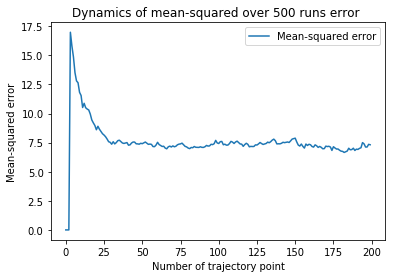

In [15]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**4, 0], [0, 10**4]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
    #Kalman filter algorithm
    for i in range(1, len(acc)):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.title('Dynamics of mean-squared over 500 runs error ')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared error'], loc = 'best')
plt.show()

We can see that final error becomes almost constant at point $\approx 25$ and estimation accuracy doesn’t increase anymore. However, it fluctuates a little. At this moment filter becomes stationary and in practice this constant filter gain can be used in the algorithm instead of calculating filter gain at every time step.

Let's make 500 more runs of filter and estimate dynamics of mean-squared error of estimation over observation interval. We'll calculate this error for filtered estimate of forecasting (extrapolation) $x_i$ with $m$ steps ahead $x_{i+m−1}$

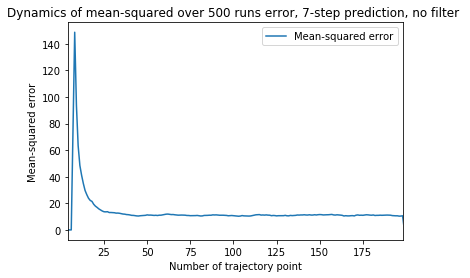

In [16]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making state vectors
    Xm = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        Xm[i,0] = x[i]
        Xm[i,1] = V[i]
        Xm[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**4, 0], [0, 10**4]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    #Kalman filter algorithm
    for i in range(1, len(acc)-m):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
        #Let's start m-step extrapolation
        m=7
        Xm[i+m-1] = np.linalg.matrix_power(PHI, m-1) @ X[i]
    
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (Xm[i,0,0] - x[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.title('Dynamics of mean-squared over 500 runs error, 7-step prediction, no filter ')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared error'], loc = 'best')
plt.xlim((4,198))
plt.show()

We can see that final error becomes almost constant also at point $\approx 25$ too and estimation accuracy doesn’t increase anymore. Moreover, it even doesn't fluctuate anymore. At this moment filter becomes stationary and in practice this constant filter gain can be used in the algorithm instead of calculating filter gain at every time step.

Let us compare mean-squared error of filtered estimate of coordinate $x_i$ with standard deviation of measurement errors. Make conclusions about effectiveness of filtration.

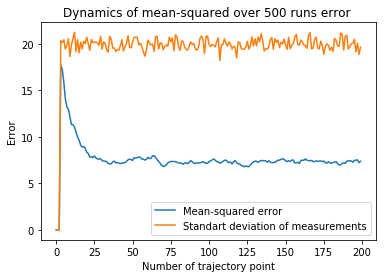

In [18]:
M=500
Errors = np.zeros((M, len(acc)))
St_Dev = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**4, 0], [0, 10**4]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
    #Kalman filter algorithm
    for i in range(1, len(acc)):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (X[i,0,0] - x[i])**2
            St_Dev[j, i] = (z[i] - x[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

St_Dev_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        St_Dev_squared[i] += (1/(M-1))*St_Dev[j, i]

plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.plot(np.sqrt(St_Dev_squared), '-')
plt.title('Dynamics of mean-squared over 500 runs error ')
plt.ylabel('Error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared error','Standart deviation of measurements'], loc = 'best')
plt.show()

Looking at this plot we can conclude that our filtration is effective

Let's make 500 runs again, but with more accurate initial filtration error covariance matrix
$$
P_{0} = 
\begin{vmatrix}
100 & 0 \\
0 & 100
\end{vmatrix}
$$
and compare mean squared error for this $P_0$ and previous one

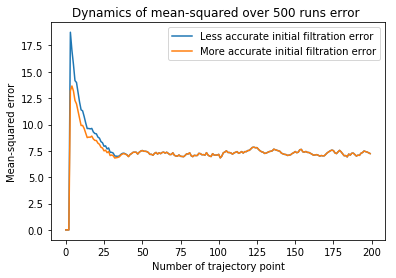

In [22]:
M=500
Errors = np.zeros((M, len(acc)))
Errors1 = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P1 = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P1[i] = np.matrix([[0, 0], [0, 0]])
    
    P1[0] = np.matrix([[10**2, 0], [0, 10**2]])
    
    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**4, 0], [0, 10**4]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
    #Kalman filter algorithm
    for i in range(1, len(acc)):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P1[i] = (PHI @ P1[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P1[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P1[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P1[i] = (np.identity(2) - K[i] @ H) @ P1[i]
    #Errors gathering
        for i in range(3, len(acc)):
            Errors1[j, i] = (X[i,0,0] - x[i])**2
            
            #Kalman filter algorithm
    for i in range(1, len(acc)):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (X[i,0,0] - x[i])**2
        
Fin_Err_squared1 = np.zeros(len(acc))
Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared1[i] += (1/(M-1))*Errors1[j, i]
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.plot(np.sqrt(Fin_Err_squared1), '-')
plt.title('Dynamics of mean-squared over 500 runs error ')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Less accurate initial filtration error', 'More accurate initial filtration error'], loc = 'best')
plt.show()

Comparing estimation results for both variants of initial $P_0$, we can see that the accuracy of initial conditions affects the estimation results only on the very first stages, that can be seen from the plots. Later they play almost no role. Thus the choice of initial conditions doesn't affect the estimation results when the number of points is very big

Now let us compare calculation errors of estimation $P_i$ provided Kalman filter algorithm with true estimation errors.

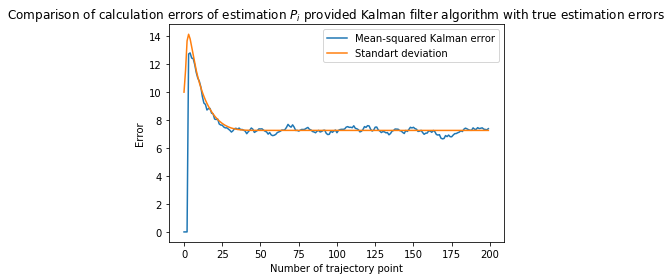

In [23]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**2, 0], [0, 10**2]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
    #Kalman filter algorithm
    for i in range(1, len(acc)):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.plot(np.sqrt(P[:, 0, 0]), '-')
plt.title('Comparison of calculation errors of estimation $P_i$ provided Kalman filter algorithm with true estimation errors')
plt.ylabel('Error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared Kalman error', 'Standart deviation'], loc = 'best')
plt.show()

We've verified that calculation errors of estimation correspond to true estimation errors

Let's run the filter for deterministic trajectory (no random disturbance)

Let's verify the following facts:

1. Filter gain approaches to zero

2. Both estimation errors and calculation errors approach to zero

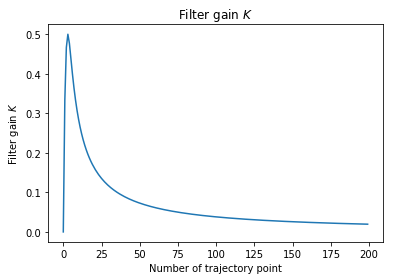

In [25]:
#noise of acceleration
sigmaacc = 0
acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
#steps, speed and time interval
x = np.zeros(len(acc))
x[0] = 5
V = np.zeros(len(acc))
V[0] = 1
T = 1
#trajectory
for i in range(len(acc)):
    x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
    V[i] = V[i-1] + acc[i-1]*T
#noise of measurements
sigmaeta = 20
eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
#measurements of the steps
z = np.zeros(len(acc))
for i in range(len(acc)):
    z[i] = x[i] + eta[i]
#making state vectors
X = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    X[i,0] = x[i]
    X[i,1] = V[i]
    X[i] = np.matrix([[x[i]], [V[i]]])
    
#making a transition matrix
PHI = np.matrix([[1, T], [0, 1]])

#making an input matrix
G = np.matrix([[T**2/2],[T]])

#making an observation matrix
H = np.matrix([1, 0])
#initial filtered estimate
X[0] = np.matrix([[2],[0]])

#initial filtration error covariance matrix
P = np.zeros((len(acc), 2, 2))
for i in range(len(acc)):
    P[i] = np.matrix([[0, 0], [0, 0]])
    
P[0] = np.matrix([[10**2, 0], [0, 10**2]])

#covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
Q = (sigmaacc**2) * (G @ G.T)

#covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
R = np.matrix([sigmaeta**2])

    
#Kalman filter algorithm
for i in range(1, len(acc)):
#Prediction(extrapolation)
    X[i] = PHI @ X[i-1]
    P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
    e[i] = (H @ P[i] @ H.T + R)**(-1)
    K[i] = e[i] * (P[i] @ H.T)
    X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
    P[i] = (np.identity(2) - K[i] @ H) @ P[i]

plt.plot(K[:,0], '-')
plt.xlabel('Number of trajectory point')
plt.ylabel('Filter gain $K$')
plt.title('Filter gain $K$')
plt.show()

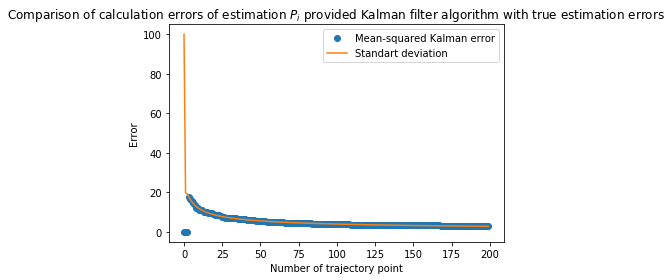

In [27]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**4, 0], [0, 10**4]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
    #Kalman filter algorithm
    for i in range(1, len(acc)):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

plt.plot(np.sqrt(Fin_Err_squared), 'o')
plt.plot(np.sqrt(P[:, 0, 0]), '-')
plt.title('Comparison of calculation errors of estimation $P_i$ provided Kalman filter algorithm with true estimation errors')
plt.ylabel('Error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared Kalman error', 'Standart deviation'], loc = 'best')
plt.show()

This means that in conditions of motion without any random disturbances, estimation error approaches to zero and filter switches off from measurements (new measurements almost do not adjust estimates)

Let's verify what happens if we use deterministic model of motion, but in fact motion is disturbed by random acceleration. In other words we won’t take into account the covariance matrix $Q$ of state noise in assimilation algorithm

We'll make 500 runs of filter and estimate dynamics of mean-squared error filtered estimate of coordinate $x_i$ over observation interval.

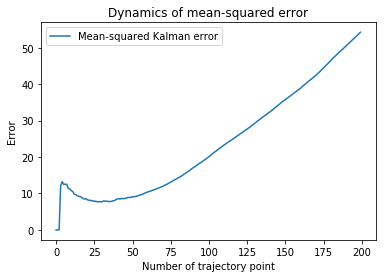

In [28]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**2, 0], [0, 10**2]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = np.matrix([[0, 0], [0, 0]])

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
    #Kalman filter algorithm
    for i in range(1, len(acc)):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.title('Dynamics of mean-squared error')
plt.ylabel('Error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared Kalman error'], loc = 'best')
plt.show()

We'll make 500 runs of filter and estimate dynamics of mean-squared error extrapolated estimate of coordinate $x_i$ $m$ steps ahead over observation interval

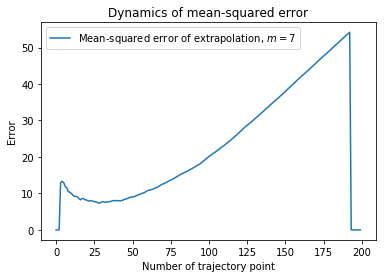

In [29]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
        
    #making state vectors
    Xm = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        Xm[i,0] = x[i]
        Xm[i,1] = V[i]
        Xm[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**2, 0], [0, 10**2]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = np.matrix([[0, 0], [0, 0]])

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
    #Kalman filter algorithm
    for i in range(1, len(acc)-m):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
        #Let's start m-step extrapolation
        m=7
        Xm[i+m-1] = np.linalg.matrix_power(PHI, m-1) @ X[i]
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.title('Dynamics of mean-squared error')
plt.ylabel('Error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared error of extrapolation, $m=7$'], loc = 'best')
plt.show()

To make conclusions about estimation in conditions of neglecting state noise in Kalman filter algorithm we would say that they mustn't be neglected in order for the filter to work properly

Now we will compare calculation errors of estimation $P_i$ (only estimation error of coordinate $x_i$) provided Kalman filter algorithm with true estimation errors


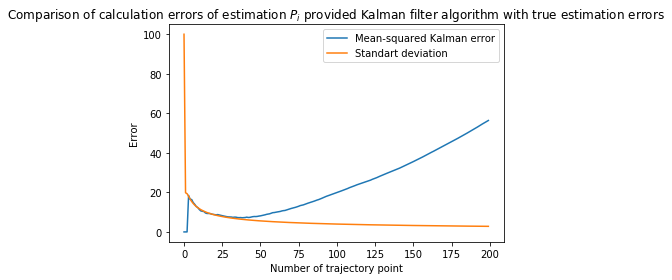

In [30]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**4, 0], [0, 10**4]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = np.matrix([[0, 0],[0, 0]])

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
    #Kalman filter algorithm
    for i in range(1, len(acc)):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.plot(np.sqrt(P[:, 0, 0]), '-')
plt.title('Comparison of calculation errors of estimation $P_i$ provided Kalman filter algorithm with true estimation errors')
plt.ylabel('Error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared Kalman error', 'Standart deviation'], loc = 'best')
plt.show()

The conclusion is that if we neglect the covariance matrix of state noise the Kalman filter algorithm diverges at some point

Let us analyze how the relationship between state and measurement noise $\frac{\sigma_W^2}{\sigma_\eta^2}$ affect time when filter gain become almost constant and estimation accuracy doesn’t increase anymore. This will be done by generating a trajectory with variance of state noise $\sigma_a^2 = 1$ and comparing estimation results with that when $\sigma_a^2 = 1$

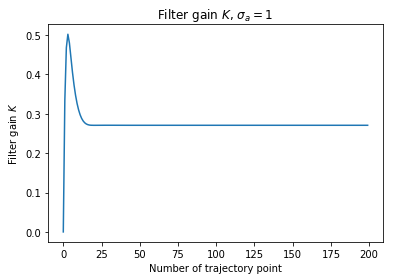

The time when filter gain becomes almost constant is appr 24
Relationship between state and measurement noise sigma_a/sigma_eta =  0.05


In [31]:
#noise of acceleration
sigmaacc = 1
acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
#steps, speed and time interval
x = np.zeros(len(acc))
x[0] = 5
V = np.zeros(len(acc))
V[0] = 1
T = 1
#trajectory
for i in range(len(acc)):
    x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
    V[i] = V[i-1] + acc[i-1]*T
#noise of measurements
sigmaeta = 20
eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
#measurements of the steps
z = np.zeros(len(acc))
for i in range(len(acc)):
    z[i] = x[i] + eta[i]
#making state vectors
X = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    X[i,0] = x[i]
    X[i,1] = V[i]
    X[i] = np.matrix([[x[i]], [V[i]]])
    
#making a transition matrix
PHI = np.matrix([[1, T], [0, 1]])

#making an input matrix
G = np.matrix([[T**2/2],[T]])

#making an observation matrix
H = np.matrix([1, 0])
#initial filtered estimate
X[0] = np.matrix([[2],[0]])

#initial filtration error covariance matrix
P = np.zeros((len(acc), 2, 2))
for i in range(len(acc)):
    P[i] = np.matrix([[0, 0], [0, 0]])
    
P[0] = np.matrix([[10**2, 0], [0, 10**2]])

#covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
Q = (sigmaacc**2) * (G @ G.T)

#covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
R = np.matrix([sigmaeta**2])

    
#Kalman filter algorithm
for i in range(1, len(acc)):
#Prediction(extrapolation)
    X[i] = PHI @ X[i-1]
    P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
    e[i] = (H @ P[i] @ H.T + R)**(-1)
    K[i] = e[i] * (P[i] @ H.T)
    X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
    P[i] = (np.identity(2) - K[i] @ H) @ P[i]

plt.plot(K[:,0], '-')
plt.xlabel('Number of trajectory point')
plt.ylabel('Filter gain $K$')
plt.title('Filter gain $K$, $\sigma_a = 1$')
plt.show()
print('The time when filter gain becomes almost constant is appr 24')
print('Relationship between state and measurement noise sigma_a/sigma_eta = ', sigmaacc/sigmaeta)

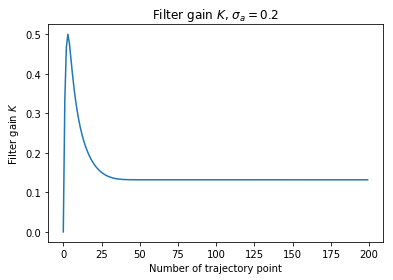

The time when filter gain becomes almost constant is appr 28
Relationship between state and measurement noise sigma_a/sigma_eta =  0.01


In [32]:
#noise of acceleration
sigmaacc = 0.2
acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
#steps, speed and time interval
x = np.zeros(len(acc))
x[0] = 5
V = np.zeros(len(acc))
V[0] = 1
T = 1
#trajectory
for i in range(len(acc)):
    x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
    V[i] = V[i-1] + acc[i-1]*T
#noise of measurements
sigmaeta = 20
eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
#measurements of the steps
z = np.zeros(len(acc))
for i in range(len(acc)):
    z[i] = x[i] + eta[i]
#making state vectors
X = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    X[i,0] = x[i]
    X[i,1] = V[i]
    X[i] = np.matrix([[x[i]], [V[i]]])
    
#making a transition matrix
PHI = np.matrix([[1, T], [0, 1]])

#making an input matrix
G = np.matrix([[T**2/2],[T]])

#making an observation matrix
H = np.matrix([1, 0])
#initial filtered estimate
X[0] = np.matrix([[2],[0]])

#initial filtration error covariance matrix
P = np.zeros((len(acc), 2, 2))
for i in range(len(acc)):
    P[i] = np.matrix([[0, 0], [0, 0]])
    
P[0] = np.matrix([[10**2, 0], [0, 10**2]])

#covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
Q = (sigmaacc**2) * (G @ G.T)

#covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
R = np.matrix([sigmaeta**2])

    
#Kalman filter algorithm
for i in range(1, len(acc)):
#Prediction(extrapolation)
    X[i] = PHI @ X[i-1]
    P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
    e[i] = (H @ P[i] @ H.T + R)**(-1)
    K[i] = e[i] * (P[i] @ H.T)
    X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
    P[i] = (np.identity(2) - K[i] @ H) @ P[i]

plt.plot(K[:,0], '-')
plt.xlabel('Number of trajectory point')
plt.ylabel('Filter gain $K$')
plt.title('Filter gain $K$, $\sigma_a = 0.2$')
plt.show()
print('The time when filter gain becomes almost constant is appr 28')
print('Relationship between state and measurement noise sigma_a/sigma_eta = ', sigmaacc/sigmaeta)

So, the bigger the relation between state and measurement noise the shorter "saturation" time of the filter is

Let us analyze sensitivity of filter to underestimated non-optimal filter gain $K$. We will generate a trajectory with variance of state noise $\sigma_a^2 = 0.2^2$ and use initial filtered estimate:

$$
X_0 = 
\begin{vmatrix}
100 \\
5
\end{vmatrix}
$$

We are going to run filter for two conditions:
1. Calculate optimal filter gain according to Kalman filter equations and calculate mean-squared error of filtered estimate of coordinate $x_i$ for 500 runs.
2. Run filter with underestimated filter gain $K$ and use steady-state value of optimal filter gain divided by 5: $K=\frac{K_{steady-state}}{5}$. Further we'll calculate mean-squared error of filtered estimate of coordinate $x_i$ in these conditions 500 runs and compare with estimation results obtained in (1)

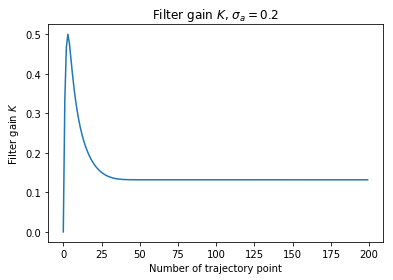

The optimal filter gain K is 0.13


In [33]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[100],[5]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**2, 0], [0, 10**2]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
    #Kalman filter algorithm
    for i in range(1, len(acc)):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

plt.plot(K[:,0], '-')
plt.xlabel('Number of trajectory point')
plt.ylabel('Filter gain $K$')
plt.title('Filter gain $K$, $\sigma_a = 0.2$')
plt.show()
print('The optimal filter gain K is approximately', 0.13)

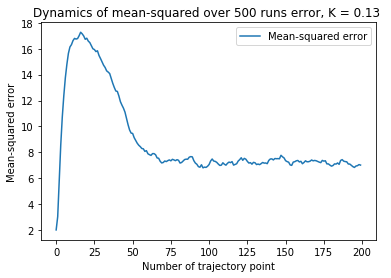

In [51]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**2, 0], [0, 10**2]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
    #Kalman filter algorithm
    for i in range(1, len(acc)):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        K[i,0] = 0.13
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    #Errors gathering
        for i in range(len(acc)):
            Errors[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.title('Dynamics of mean-squared over 500 runs error, K = 0.13 ')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared error'], loc = 'best')
plt.show()

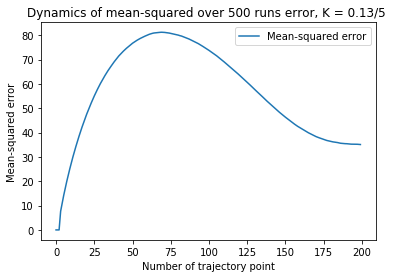

In [52]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #noise of acceleration
    sigmaacc = 0.2
    acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)
    #steps, speed and time interval
    x = np.zeros(len(acc))
    x[0] = 5
    V = np.zeros(len(acc))
    V[0] = 1
    T = 1
    #trajectory
    for i in range(len(acc)):
        x[i] = x[i-1] + V[i-1]*T + acc[i-1]*(T**2)/2
        V[i] = V[i-1] + acc[i-1]*T
    #noise of measurements
    sigmaeta = 20
    eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)
    #measurements of the steps
    z = np.zeros(len(acc))
    for i in range(len(acc)):
        z[i] = x[i] + eta[i]
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = V[i]
        X[i] = np.matrix([[x[i]], [V[i]]])
    
    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])
    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    
    P[0] = np.matrix([[10**2, 0], [0, 10**2]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])

    
    #Kalman filter algorithm
    for i in range(1, len(acc)):
    #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        K[i,0] = 0.13/5
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    #Errors gathering
        for i in range(3, len(acc)):
            Errors[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared[i] += (1/(M-1))*Errors[j, i]

plt.plot(np.sqrt(Fin_Err_squared), '-')
plt.title('Dynamics of mean-squared over 500 runs error, K = 0.13/5 ')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Mean-squared error'], loc = 'best')
plt.show()

As was asked in this laboratory work we developed standard Kalman filter algorithm for tracking a moving object which trajectory is disturbed by random acceleration. As an important outcome we got deeper understanding of Kalman filter parameters and their roles in estimation. We analyzed the sensitivity of estimations to choice of non-optimal parameters and
dependence on initial conditions.